\begin{equation}
    k_B = J = 1
\end{equation}

In [1]:
using Pkg
Pkg.activate("./Packages/Project.toml");

  Activating project at `~/Repos/Heisenberg-Model-3D/Packages`


In [2]:
using DelimitedFiles 
using LinearAlgebra
using Statistics
using Random
using Printf
using Plots;

In [3]:
function RandomSpin()
    """Creates a random unit vector"""
    θ = rand(0:1e-6:π)
    ϕ = rand(0:1e-6:2π)
    return [sin(θ)*cos(ϕ), sin(θ)*sin(ϕ), cos(θ)]
end

function AcceptanceProbability(Spin1, Spin2, n, β)
    """Computes the probability of adding Spin2 - neighbour of
    Spin1 - to the cluster. It uses the temperature β and the 
    vector of reflection n"""
    return 1 - exp(min(0,-2β*transpose(Spin1)*n*transpose(Spin2)*n))
end

function ReflectSpin(S,n,state)
    """Reflectes the spin state[S] around the plane defined by the
    normal vector n"""
    state[S] -=  2(transpose(state[S])*n)*n
end

function GetNeighbours(L,L2,L3)
    """Gets the coordinates of the 6 neighbours of every spin in the state. It uses 
    periodic boundery conditions in a 3D lattice of length L (area L2, volume L3). 
    The L3 × 6 matriz it returns contains the neighbours as folows: 
    [Up-Down-Left-Right-Front-Back]"""
    Neighbours = zeros(Int16,L3,6)
    for x in 1:L3
        Neighbours[x,:] = [L2*((x-1)÷L2)+(x-1-L+L2)%L2+1,
            L2*((x-1)÷L2)+(x-1+L)%L2+1,
            L*((x-1)÷L)+(x+L-2)%L+1,
            L*((x-1)÷L)+(x)%L+1,
            (x-L2+L3-1)%L3+1,
            (x+L2-1)%L3+1]
    end
    return Neighbours
end

function Grow_Reflect(S, Cluster, n, β, L, L2, L3, state, neighbours)
    """Checks every neighbour of spin state[S] and adds them to the Cluster given
        a certain probability (refair to AcceptanceProbability). Finally, it 
        reflects the spin around the normal vector n (refair to ReflectSpin)"""
    #Checks neighbours
    for Sn in neighbours[S,:]
        if Sn ∉ Cluster && rand(0:1e-15:1) < AcceptanceProbability(state[S],state[Sn],n,β)
            #Adds neighbour to Cluster
            push!(Cluster,Sn)
            #Checks neighbours of neighbour
            Grow_Reflect(Sn, Cluster, n, β, L, L2, L3, state, neighbours)
        end
    end
    #Reflects the spin
    ReflectSpin(S,n, state)
end

function NewState(state, L, L2, L3, β, neighbours)
    """Chooses a randon spin from the state with lattice sice L, and also a
    random normal vector. From there it builds the cluster using Wolff algorithm
    (see Grow_Reflect)"""
    n = RandomSpin()     #Initial random Normal Vector
    S0 = rand(1:1:L3)    #Initial random Spin
    Cluster = [S0]       #Stores the indexes of the spins added to the cluster
    Grow_Reflect(S0, Cluster, n, β, L, L2, L3, state, neighbours) #Builds cluster and flips for new state
end;

In [4]:
function Magnetization(state)
    """Returns the magnetization as the norm of the sum of all spins in the grid"""
    return norm([sum(state[:,1]),sum(state[:,2]),sum(state[:,3])])
end

function Energy(state,L3,neighbours)
    """Returns the energy of a state"""
    energy = 0.0
    #Goes through every spin in the lattice
    for ii in 1:L3  
        Sp = [0,0,0]
        #Only checks 3 out the 6 neighbourds to avoid double counting of bounderies
        for Sn in neighbours[ii,[2,4,6]] 
            Sp += state[Sn,:]
        end
        energy -= dot(Sp,state[ii,:])
    end
    return energy
end

function Variance(X)
    """Returns the variance of any array X"""
    return mean(X.^2) - mean(X)^2
end

function MeasureAll(βs,L3,neighbours,N)
    """Reads states and returns arrays with magnetization, energy, suceptibility 
    and specific heat for every tempeture."""
    Ms = [] #Magnetization 
    Es = [] #Energy 
    χs = [] #Suceptibility 
    Cs = [] #Specific Heat 
    for β in βs
        M = [] #Magnetization (single T)
        E = [] #Energy (single T)
        χ = [] #Suceptibility (single T)
        C = [] #Specific Heat (single T)
        print("Reading ",β,"...\n")
        File = readdlm("./Data_10/T_"*string(β)*".txt")
        for jj in 1:N
            push!(M,Magnetization(File[(L3*(jj-1)+1:(L3*jj)),:]))
            push!(E, Energy(File[(L3*(jj-1)+1:(L3*jj)),:],L3,neighbours))
        end
        push!(Ms,sum(M))
        push!(Es,sum(E))
        push!(χs,Variance(M)*β)
        push!(Cs,Variance(E)*β^2)
    end 
    return Ms, Es, χs, Cs
end

function TopologicalDefects(state)
    """COMING SOON!"""
end;

In [5]:
function Proceed(state, β, n_samples, n_flips, L, L2, L3, neighbours)
    """Creates a sequence of states and saves to a file once every fixed number of flips.
    This is done for a single value of β in a lattice of size L."""
    for jj in 1:n_flips*n_samples
        NewState(state, L, L2, L3, β, neighbours)
        if jj%n_flips == 0
            open("./Data_"*string(L)*"/T_"*string(β)*".txt", "a") do io
                writedlm(io, state)
            end
        end
    end
end;

In [6]:
"""----- MAIN -----"""
L = 10  #Lattice size
L2 = L*L   #Lattice Area
L3 = L*L2  #Lattice Volume
n_samples = 300
#Random.seed!(51)
state = [RandomSpin() for i in 1:L3] #The 3D lattice is store as a 1D-Array
neighbours = GetNeighbours(L,L2,L3)  #Matrix with the indexes of the 6 adjacent spins of each in the lattice
Temperatures = [kk for kk in 0.5:.05:2.5 ]
βs = 1 ./ Temperatures;

In [7]:
for kk in βs                         #Loop over all tempetures
    n_flips = 1000
    if kk > .69
        n_flips = 10
    end
    print("Doing ",kk,"...\n")
    Proceed(state, kk, n_samples, n_flips, L, L2, L3, neighbours)
end

Doing 2.0...
Doing 1.8181818181818181...
Doing 1.6666666666666667...
Doing 1.5384615384615383...
Doing 1.4285714285714286...
Doing 1.3333333333333333...
Doing 1.25...
Doing 1.1764705882352942...
Doing 1.1111111111111112...
Doing 1.0526315789473684...
Doing 1.0...
Doing 0.9523809523809523...
Doing 0.9090909090909091...
Doing 0.8695652173913044...
Doing 0.8333333333333334...
Doing 0.8...
Doing 0.7692307692307692...
Doing 0.7407407407407407...
Doing 0.7142857142857143...
Doing 0.6896551724137931...
Doing 0.6666666666666666...
Doing 0.6451612903225806...
Doing 0.625...
Doing 0.6060606060606061...
Doing 0.5882352941176471...
Doing 0.5714285714285714...
Doing 0.5555555555555556...
Doing 0.5405405405405405...
Doing 0.5263157894736842...
Doing 0.5128205128205129...
Doing 0.5...
Doing 0.48780487804878053...
Doing 0.47619047619047616...
Doing 0.46511627906976744...
Doing 0.45454545454545453...
Doing 0.4444444444444444...
Doing 0.4347826086956522...
Doing 0.425531914893617...
Doing 0.416666666666

In [8]:
Ms,Es,χs,Cs = MeasureAll(βs,L3,neighbours,n_samples);

Reading 2.0...
Reading 1.8181818181818181...
Reading 1.6666666666666667...
Reading 1.5384615384615383...
Reading 1.4285714285714286...
Reading 1.3333333333333333...
Reading 1.25...
Reading 1.1764705882352942...
Reading 1.1111111111111112...
Reading 1.0526315789473684...
Reading 1.0...
Reading 0.9523809523809523...
Reading 0.9090909090909091...
Reading 0.8695652173913044...
Reading 0.8333333333333334...
Reading 0.8...
Reading 0.7692307692307692...
Reading 0.7407407407407407...
Reading 0.7142857142857143...
Reading 0.6896551724137931...
Reading 0.6666666666666666...
Reading 0.6451612903225806...
Reading 0.625...
Reading 0.6060606060606061...
Reading 0.5882352941176471...
Reading 0.5714285714285714...
Reading 0.5555555555555556...
Reading 0.5405405405405405...
Reading 0.5263157894736842...
Reading 0.5128205128205129...
Reading 0.5...
Reading 0.48780487804878053...
Reading 0.47619047619047616...
Reading 0.46511627906976744...
Reading 0.45454545454545453...
Reading 0.4444444444444444...
Rea

(Any[261931.2480279856, 257730.25704474698, 253095.61098767573, 248366.54088830206, 243692.29478246064, 239453.74241943905, 233479.95047590218, 227910.44849608198, 222301.54362505506, 216074.90392559487  …  20776.62634310354, 19285.7410920852, 18737.006065891528, 18226.67850242597, 17306.2826197713, 16430.112220093964, 16962.77251283549, 16292.630518683785, 15720.706462240114, 15363.689731704613], Any[-741517.6391324069, -724899.8166277814, -708465.309838834, -690820.5455778022, -673201.4944588254, -655486.70208017, -636310.400421033, -616549.2832535881, -598046.5266275165, -576800.5320337203  …  -164691.4377124541, -158264.95176943493, -154132.08423102283, -150409.9283770673, -146817.24733109522, -141604.8651692269, -138208.80044526153, -135974.43175288895, -131831.96900242096, -129860.25379687152], Any[77.76221159449778, 81.01865227545865, 95.83068710247366, 103.4978709488104, 135.49502220171104, 121.84794632190217, 173.83270278922282, 176.58467981115203, 233.06795473947813, 217.7099

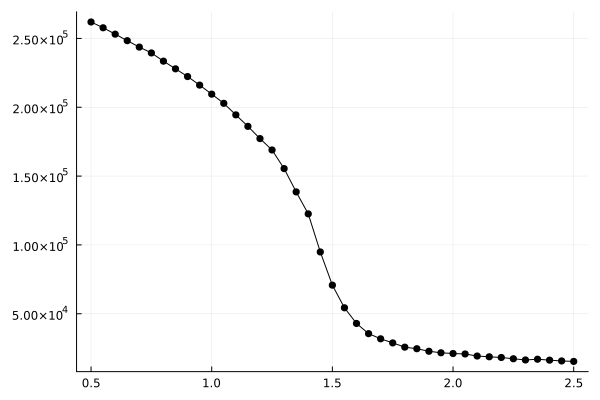

In [18]:
plot(Temperatures,Ms, 
    shape = :circle,
    color = :black,
    legend = false,
    markersize = 4)

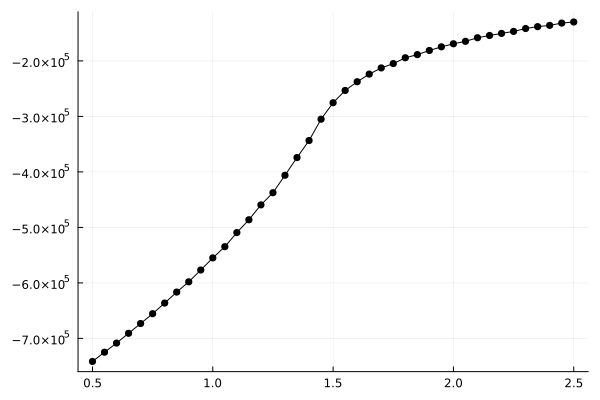

In [19]:
plot(Temperatures,Es,
    shape = :circle,
    color = :black,
    legend = false,
    markersize = 4)

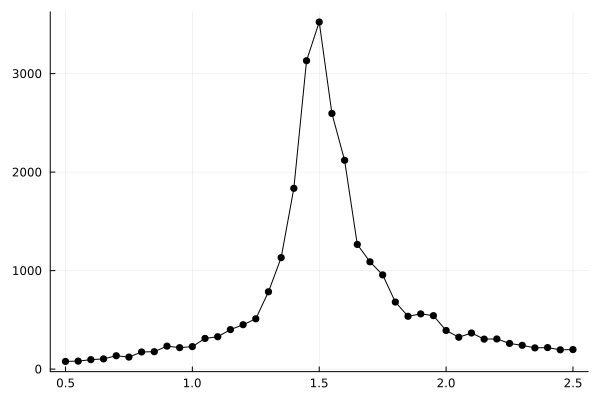

In [20]:
plot(Temperatures,χs,
    shape = :circle,
    color = :black,
    legend = false,
    markersize = 4)

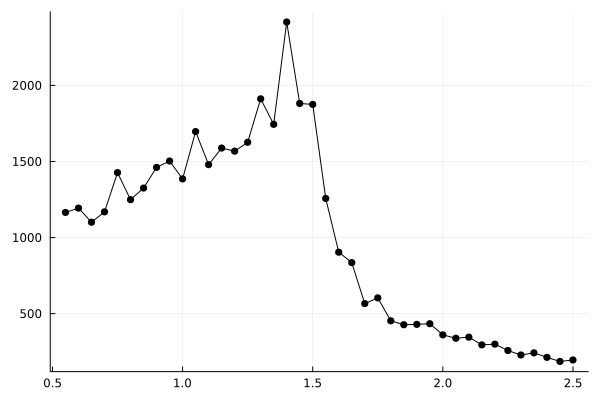

In [23]:
plot(Temperatures[2:end],Cs[2:end],
    shape = :circle,
    color = :black,
    legend = false,
    markersize = 4)